In [117]:
%matplotlib inline
import os
import umap
import seaborn as sns


from ipywidgets import Select, SelectMultiple, interactive,  Layout, Box, Label

from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, feature_selection
import sklearn.metrics as metrics
import matplotlib.patches as mpatches


import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
#import seaborn as sns
## for processing
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.feature_selection 
import nltk
import gensim
from tensorflow.keras import preprocessing as kprocessing
#перед использованием раскомментировать
nltk.download("stopwords")
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/msermakov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/msermakov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [118]:
biology = pd.read_excel("./data/articles/Biology.xlsx").dropna().head(300)
biology["class"] = "biology"
arts = pd.read_excel("./data/articles/Arts.xlsx").dropna().head(300)
arts["class"] = "arts"
chemistry = pd.read_excel("./data/articles/Chemistry.xlsx").dropna().head(300)
chemistry["class"] = "chemistry"
evolution = pd.read_excel("./data/articles/Evolution.xlsx").dropna().head(300)
evolution["class"] = "evolution"
math = pd.read_excel("./data/articles/Math.xlsx").dropna().head(300)
math["class"] = "math"
physics = pd.read_excel("./data/articles/Physics.xlsx").dropna().head(300)
physics["class"] = "physics"
policy_ethics = pd.read_excel("./data/articles/PolicyEthics.xlsx").dropna().head(300)
policy_ethics["class"] = "policy_ethics"
articles = pd.concat([biology, arts, chemistry, evolution, math, physics, policy_ethics])

In [119]:
articles.columns = ["text", "title", "class"]
articles = articles.dropna()
articles.head(10)

text  \
0  This spring’s emergence of periodical cicadas ...   
1  In the 1980s, scientists discovered that oyste...   
2  In September 2017, when Hurricane Maria hit Pu...   
3  A few plants in the cabbage and mustard family...   
4  The following essay is reprinted with permissi...   
5  Dinosaur and fossil aficionados are intimately...   
6  The human body replaces its own cells regularl...   
7  Born in England in 1799, Anna Atkins was an am...   
8  Like an expert moviegoer who can instantly rec...   
9  In 1986, Yiu-Kwok Chan from Agriculture Canada...   

                                               title    class  
0       Brood X Cicadas Could Cause a Bird Baby Boom  biology  
1        How a Carnivorous Mushroom Poisons Its Prey  biology  
2  What Monkeys Can Teach Humans about Resilience...  biology  
3  Killer Leaves Emerge from Plant-Butterfly Arms...  biology  
4  Chocolate’s Secret Ingredient Is Fermenting Mi...  biology  
5  The Asteroid That Killed the Dinosaurs Created...  biology  
6     Our Bodies Replace Billions of Cells Every Day  biology  
7  Female Botanist Published the First Ever Photo...  biology  
8  Some Deep-Sea Bacteria Are So Strange, Our Imm...  biology  
9                  Guardians of the Microbial Galaxy  biology

In [120]:
counter=CountVectorizer(
        token_pattern=r"[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+", 
        stop_words="english")

def get_most_freq_words(text, count=-1):
    try:
        res=counter.fit_transform([text])
    except ValueError:
        return None
    
    frq = sorted([(i, res[0,i]) for i in range(res[0].shape[1])], 
                 key = lambda x: x[1], reverse = True)[:count]
    vocab = {w:res[0,i] for w,i in counter.vocabulary_.items()}
    return [[w for w, n in counter.vocabulary_.items() if n==i][0] 
            for i, f in frq]

In [121]:
def normalize(text):
    words = get_most_freq_words(text)
    if not words:
        words = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', text)
        sw = stopwords.words('english')
        lst_text = [word for word in words if word not in sw][:1001]

    # Стемминг
    ps = nltk.stem.porter.PorterStemmer()
    words = [ps.stem(word) for word in words]

    # Лемматизация
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    words = [lem.lemmatize(word) for word in words]

    return " ".join(words)

In [122]:
articles["cleaned"] = articles.text.apply(lambda text: normalize(text))
articles.head(10)

text  \
0  This spring’s emergence of periodical cicadas ...   
1  In the 1980s, scientists discovered that oyste...   
2  In September 2017, when Hurricane Maria hit Pu...   
3  A few plants in the cabbage and mustard family...   
4  The following essay is reprinted with permissi...   
5  Dinosaur and fossil aficionados are intimately...   
6  The human body replaces its own cells regularl...   
7  Born in England in 1799, Anna Atkins was an am...   
8  Like an expert moviegoer who can instantly rec...   
9  In 1986, Yiu-Kwok Chan from Agriculture Canada...   

                                               title    class  \
0       Brood X Cicadas Could Cause a Bird Baby Boom  biology   
1        How a Carnivorous Mushroom Poisons Its Prey  biology   
2  What Monkeys Can Teach Humans about Resilience...  biology   
3  Killer Leaves Emerge from Plant-Butterfly Arms...  biology   
4  Chocolate’s Secret Ingredient Is Fermenting Mi...  biology   
5  The Asteroid That Killed the Dinosaurs Created...  biology   
6     Our Bodies Replace Billions of Cells Every Day  biology   
7  Female Botanist Published the First Ever Photo...  biology   
8  Some Deep-Sea Bacteria Are So Strange, Our Imm...  biology   
9                  Guardians of the Microbial Galaxy  biology   

                                             cleaned  
0  cicada cicada speci popul say year year s bird...  
1  s nematod nematod poison worm calcium fungi sc...  
2  social s say macaqu platt santiago island monk...  
3  plant egg speci butterfli famili plant say but...  
4  chocol ferment bean cacao s bacteria flavor pr...  
5  s forest meteorit new speci say year amazon fo...  
6  cell bodi day equival human live mass percent ...  
7  alga atkin alga known seawe speci british meth...  
8  immun bacteria lp s deep-sea microb new recept...  
9  microbi cultur collect collect world bacteri s...

In [144]:
corpus = articles["cleaned"]

# Сформируем список юниграмм
lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)
lst_corpus

[['cicada',
  'cicada',
  'speci',
  'popul',
  'say',
  'year',
  'year',
  's',
  'bird',
  'insect',
  'period',
  'predat',
  'univers',
  'brood',
  'emerg',
  'emerg',
  'liebhold',
  'popul',
  'biologist',
  'eastern',
  'food',
  'forest',
  'research',
  'studi',
  'studi',
  'american',
  'california',
  'dead',
  'egg',
  'entomologist',
  'insect',
  'koenig',
  'leav',
  'mouse',
  'number',
  'predat',
  'research',
  'time',
  'u',
  'unusu',
  'x',
  'advantag',
  'anim',
  'arkansa',
  'behavior',
  'benefit',
  'bird',
  'bodi',
  'brood',
  'chang',
  'compar',
  'cycl',
  'davi',
  'did',
  'drop',
  'ecosystem',
  'emerg',
  'emerg',
  'evolutionari',
  'feed',
  'follow',
  'forest',
  'hard',
  'higher',
  'impact',
  'impact',
  'includ',
  'increas',
  'instead',
  'lay',
  'lot',
  'mammal',
  'mammal',
  'mate',
  'mix',
  'nest',
  'nitrogen',
  'normal',
  'number',
  'pattern',
  'percent',
  'prior',
  'pul',
  'realli',
  'result',
  'reveal',
  'signif

In [124]:
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, vector_size=50,   
            window=8, min_count=1, sg=1, epochs=10)

In [125]:
def text_to_vec(text):
    words = text.split(" ")
    vec = [nlp.wv.get_vector(word) for word in words if word in list(nlp.wv.index_to_key)]
    return np.asarray(vec).reshape(-1)

In [126]:
articles["vec"] = articles.cleaned.apply(lambda text: text_to_vec(text))
articles

text  \
0    This spring’s emergence of periodical cicadas ...   
1    In the 1980s, scientists discovered that oyste...   
2    In September 2017, when Hurricane Maria hit Pu...   
3    A few plants in the cabbage and mustard family...   
4    The following essay is reprinted with permissi...   
..                                                 ...   
311  In the midst of the COVID-19 pandemic, access ...   
312  In the weeks to come, we’re about to relearn t...   
314  As lawmakers in the United States turn their f...   
317  Thomas Gillespie was supposed to be in Tanzani...   
318  The United Nations postponed an important year...   

                                                 title          class  \
0         Brood X Cicadas Could Cause a Bird Baby Boom        biology   
1          How a Carnivorous Mushroom Poisons Its Prey        biology   
2    What Monkeys Can Teach Humans about Resilience...        biology   
3    Killer Leaves Emerge from Plant-Butterfly Arms...        biology   
4    Chocolate’s Secret Ingredient Is Fermenting Mi...        biology   
..                                                 ...            ...   
311        Yes, Liquor Stores Are Essential Businesses  policy_ethics   
312  The Pandemic Shows Why the U.S. Must Invest in...  policy_ethics   
314  Congress Needs More Scientific Expertise to Fi...  policy_ethics   
317  Coronavirus Disrupts Vital Field Research—Incl...  policy_ethics   
318  U.N. Postpones Global Climate Summit Over Pand...  policy_ethics   

                                               cleaned  \
0    cicada cicada speci popul say year year s bird...   
1    s nematod nematod poison worm calcium fungi sc...   
2    social s say macaqu platt santiago island monk...   
3    plant egg speci butterfli famili plant say but...   
4    chocol ferment bean cacao s bacteria flavor pr...   
..                                                 ...   
311  alcohol aud peopl liquor store access essenti ...   
312  s research discoveri public america billion hu...   
314  lawmak scienc s technolog advisor advisori bra...   
317  s gillespi say scientist local professor resea...   
318  countri climat u said s summit e meet n pari w...   

                                                   vec  
0    [0.036714375, -0.036228206, 0.078160584, 0.063...  
1    [0.206919, -0.6726126, -0.87596405, 0.8305603,...  
2    [-0.1304029, -0.62950915, -0.29873028, -0.0137...  
3    [0.794372, 0.4631958, 0.11296791, 0.8035424, -...  
4    [0.14886759, 0.11187994, -0.41781557, 0.177325...  
..                                                 ...  
311  [0.33140555, -0.010198596, -0.7914665, -0.1404...  
312  [0.206919, -0.6726126, -0.87596405, 0.8305603,...  
314  [-0.31020558, 0.36993322, -0.18058816, 0.44611...  
317  [0.206919, -0.6726126, -0.87596405, 0.8305603,...  
318  [-0.19407079, 0.2453625, 0.53173774, -0.371172...  

[2100 rows x 5 columns]

In [127]:
pad_data = kprocessing.sequence.pad_sequences(
    articles.vec, 
    maxlen=max(articles.vec.apply(lambda vec: len(vec))), 
    padding="post", 
    truncating="post",
    dtype="float32"
)

In [128]:
fit = umap.UMAP(
    n_neighbors=500,
    min_dist=0.01,
    n_components=2,
    metric="euclidean",
    random_state=42
)
    
umap_result = fit.fit_transform(pad_data)

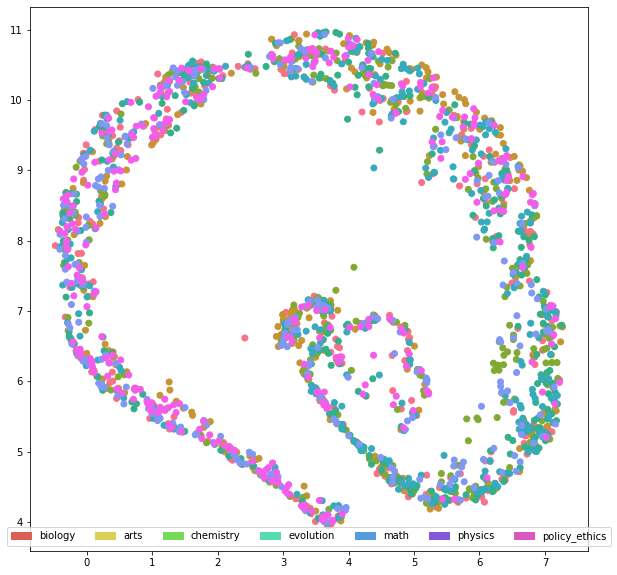

In [129]:
keys = list(articles["class"].value_counts().keys())
themes_dict = {keys[i]:i for i in range(len(keys))}
colors = [sns.color_palette("husl", len(themes_dict))[x] for x in articles["class"].map(themes_dict)]

fig = plt.figure(figsize=(10, 10))
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=colors)

patches = [mpatches.Patch(color=sns.color_palette("hls", len(themes_dict))[i], label=keys[i]) for i in range(len(keys))]
plt.legend(handles=patches, ncol=10, loc="lower center")

In [130]:
x = articles["cleaned"].copy()
y = articles["class"].copy()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [131]:
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,3))

In [132]:
x_train

175    s peopl moral problem child trolley adult arti...
62     pesticid pesticid dr food residu sampl unsaf w...
271    trig s plimpton tabl base exact t ancient mans...
35     fusion american bomb decis scientif anniversar...
6      water life s molecul say chemic acid form rese...
                             ...                        
170    museum s histori specimen brazil natur build c...
142    irish caribbean s st day guin patrick british ...
200    polic s use peopl ga tear bullet lethal weapon...
110    wolfram s physic say rule work model new scien...
315    s dna bear lindqvist creatur gemmel ness loch ...
Name: cleaned, Length: 1470, dtype: object

In [133]:
corpus = x_train
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [134]:
X_train.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.02483152, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.03216041, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [135]:
dic_vocabulary

{'peopl': 6392,
 'moral': 5738,
 'problem': 6866,
 'child': 1325,
 'adult': 179,
 'articl': 537,
 'caus': 1182,
 'dilemma': 2383,
 'mail': 5338,
 'fever': 3325,
 'legal': 5000,
 'life': 5048,
 'malaria': 5396,
 'purpos': 7089,
 'recreat': 7340,
 'technolog': 8935,
 'use': 9529,
 'agenda': 233,
 'american': 329,
 'anthoni': 406,
 'argu': 503,
 'attach': 615,
 'care': 1129,
 'cheat': 1309,
 'consid': 1736,
 'develop': 2294,
 'did': 2330,
 'disabl': 2409,
 'diseas': 2444,
 'doctor': 2501,
 'doe': 2507,
 'don': 2527,
 'drug': 2582,
 'easier': 2633,
 'epidem': 2869,
 'exampl': 3001,
 'expo': 3139,
 'feel': 3307,
 'girl': 3693,
 'good': 3745,
 'govern': 3757,
 'inequ': 4396,
 'issu': 4630,
 'kill': 4767,
 'live': 5177,
 'mean': 5511,
 'medic': 5547,
 'mosquito': 5744,
 'object': 6057,
 'organ': 6203,
 'poor': 6641,
 'posse': 6673,
 'poverti': 6712,
 'provid': 7030,
 'scienc': 7904,
 'secur': 7975,
 'skeptic': 8250,
 'social': 8313,
 'societi': 8316,
 'solubl': 8331,
 'suffer': 8726,
 'suppor

In [136]:
# X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]

In [137]:
# sns.heatmap(X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1).set_title('Sparse Matrix Sample')

In [138]:
#попытка уменьшить плотность матрицы, методом хи квадрат
# X_names = vectorizer.get_feature_names()
# p_value_limit = 0.80
# dtf_features = pd.DataFrame()
# for cat in np.unique(y_train):
#     chi2, p = feature_selection.chi2(X_train, y_train==cat)
#     dtf_features = dtf_features.append(pd.DataFrame(
#                    {"feature":X_names, "score":1-p, "y":cat}))
#     dtf_features = dtf_features.sort_values(["y","score"], 
#                     ascending=[True,False])
#     dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
# X_names = dtf_features["feature"].unique().tolist()

# for cat in np.unique(y):
#    print("# {}:".format(cat))
#    print("  . selected features:",
#          len(dtf_features[dtf_features["y"]==cat]))
#    print("  . top features:", ",".join(
# dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
#    print(" ")
    
# vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
# vectorizer.fit(corpus)
# X_train = vectorizer.transform(corpus)
# dic_vocabulary = vectorizer.vocabulary_

In [149]:
classifier = naive_bayes.MultinomialNB()
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
model["classifier"].fit(X_train, y_train)

X_test = x_test
predicted = model.predict(X_test)
print(predicted)
predicted_prob = model.predict_proba(X_test)
print(predicted_prob)

['math' 'biology' 'evolution' 'biology' 'chemistry' 'chemistry' 'physics'
 'policy_ethics' 'evolution' 'physics' 'policy_ethics' 'chemistry'
 'policy_ethics' 'physics' 'biology' 'physics' 'evolution' 'physics'
 'chemistry' 'math' 'evolution' 'physics' 'biology' 'physics' 'evolution'
 'policy_ethics' 'physics' 'biology' 'evolution' 'policy_ethics'
 'policy_ethics' 'evolution' 'evolution' 'chemistry' 'physics'
 'policy_ethics' 'chemistry' 'arts' 'policy_ethics' 'evolution' 'math'
 'physics' 'policy_ethics' 'chemistry' 'chemistry' 'evolution' 'physics'
 'policy_ethics' 'biology' 'math' 'physics' 'math' 'physics'
 'policy_ethics' 'arts' 'arts' 'evolution' 'policy_ethics' 'evolution'
 'policy_ethics' 'physics' 'policy_ethics' 'policy_ethics' 'biology'
 'math' 'physics' 'arts' 'chemistry' 'physics' 'policy_ethics' 'arts'
 'math' 'math' 'policy_ethics' 'arts' 'evolution' 'evolution' 'physics'
 'policy_ethics' 'arts' 'biology' 'evolution' 'biology' 'arts' 'evolution'
 'physics' 'arts' 'evoluti

In [140]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("По классам:")
print(metrics.classification_report(y_test, predicted))

Accuracy: 0.7
По классам:
               precision    recall  f1-score   support

         arts       0.68      0.47      0.56        99
      biology       0.68      0.60      0.64        97
    chemistry       0.72      0.66      0.69        89
    evolution       0.76      0.74      0.75        95
         math       0.89      0.81      0.85        86
      physics       0.62      0.83      0.71        77
policy_ethics       0.64      0.87      0.74        87

     accuracy                           0.70       630
    macro avg       0.71      0.71      0.70       630
 weighted avg       0.71      0.70      0.70       630



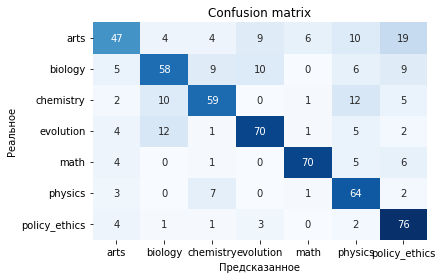

In [141]:
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Предсказанное", ylabel="Реальное", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)
plt.show()

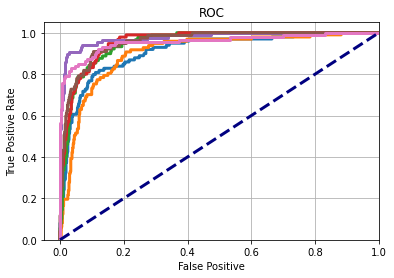

In [142]:
fig, ax = plt.subplots()
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax.plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax.plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax.set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive', 
          ylabel="True Positive Rate", 
          title="ROC")
#ax.legend(loc="lower right")
ax.grid(True)
plt.show()

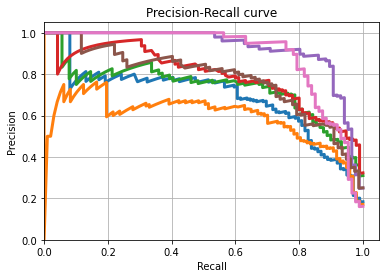

In [143]:
fig, ax = plt.subplots()
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax.plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax.set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
#ax.legend(loc="best")
ax.grid(True)
plt.show()